<a href="https://colab.research.google.com/github/aulia21011/sentiment-pollution/blob/main/POLLUTION_SENTIMENT_CLASS_BERT_PYSASTRAWI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

1. Text Cleaning & Case Folding
2. Tokenizing
3. Stopwords
4. Stemming

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
pip install nltk

In [ ]:
pip install PySastrawi

In [ ]:
import nltk
nltk.download() #d #enter #all-nltk #enter #q

In [ ]:
import pandas as pd
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory


df = pd.read_csv("/content/sentimen polusi indonesia - labeled.csv", delimiter=',')
print(df.shape)
df['Tweet'].head(5)

(1786, 2)


0    Udah numpuk emosi gue dari kemarin sama orang2...
1    untuk kesekian kalinya lagi lagi lagi apa? Ya ...
2    bulan ini breakout parah karena memangmau haid...
3    yang bikin polusi mah sono anjir. lu minim pol...
4    GA USAH LEBAY. Jakarta udaranya masih biasa sa...
Name: Tweet, dtype: object

In [ ]:
# Preprocessing

xs = df['Tweet'].str.lower()  # Mengubah teks menjadi lowercase
xs = xs.apply(lambda x: re.sub(r'\d+', '', x))  # Menghapus angka
xs = xs.apply(lambda x: x.translate(str.maketrans('', '',string.punctuation))) #Menghapus tanda baca
xs = xs.apply(lambda x: word_tokenize(x))  # Tokenisasi kata-kata

# Menghapus stopwords
stop_words = set(stopwords.words('indonesian'))
xs = xs.apply(lambda tokens: [word for word in tokens if word not in stop_words])

In [ ]:
# Stemming (Memecah kata dasar) menggunakan PySastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

tokens = xs.apply(lambda tokens: [stemmer.stem(word) for word in tokens])

In [ ]:
# @title
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)
stopwords.update(["yang","kan","ga","di","pada","ya","adalah","dan","ke","dengan",
                  "nya","dari","akan","itu"]) #adding our own stopwords

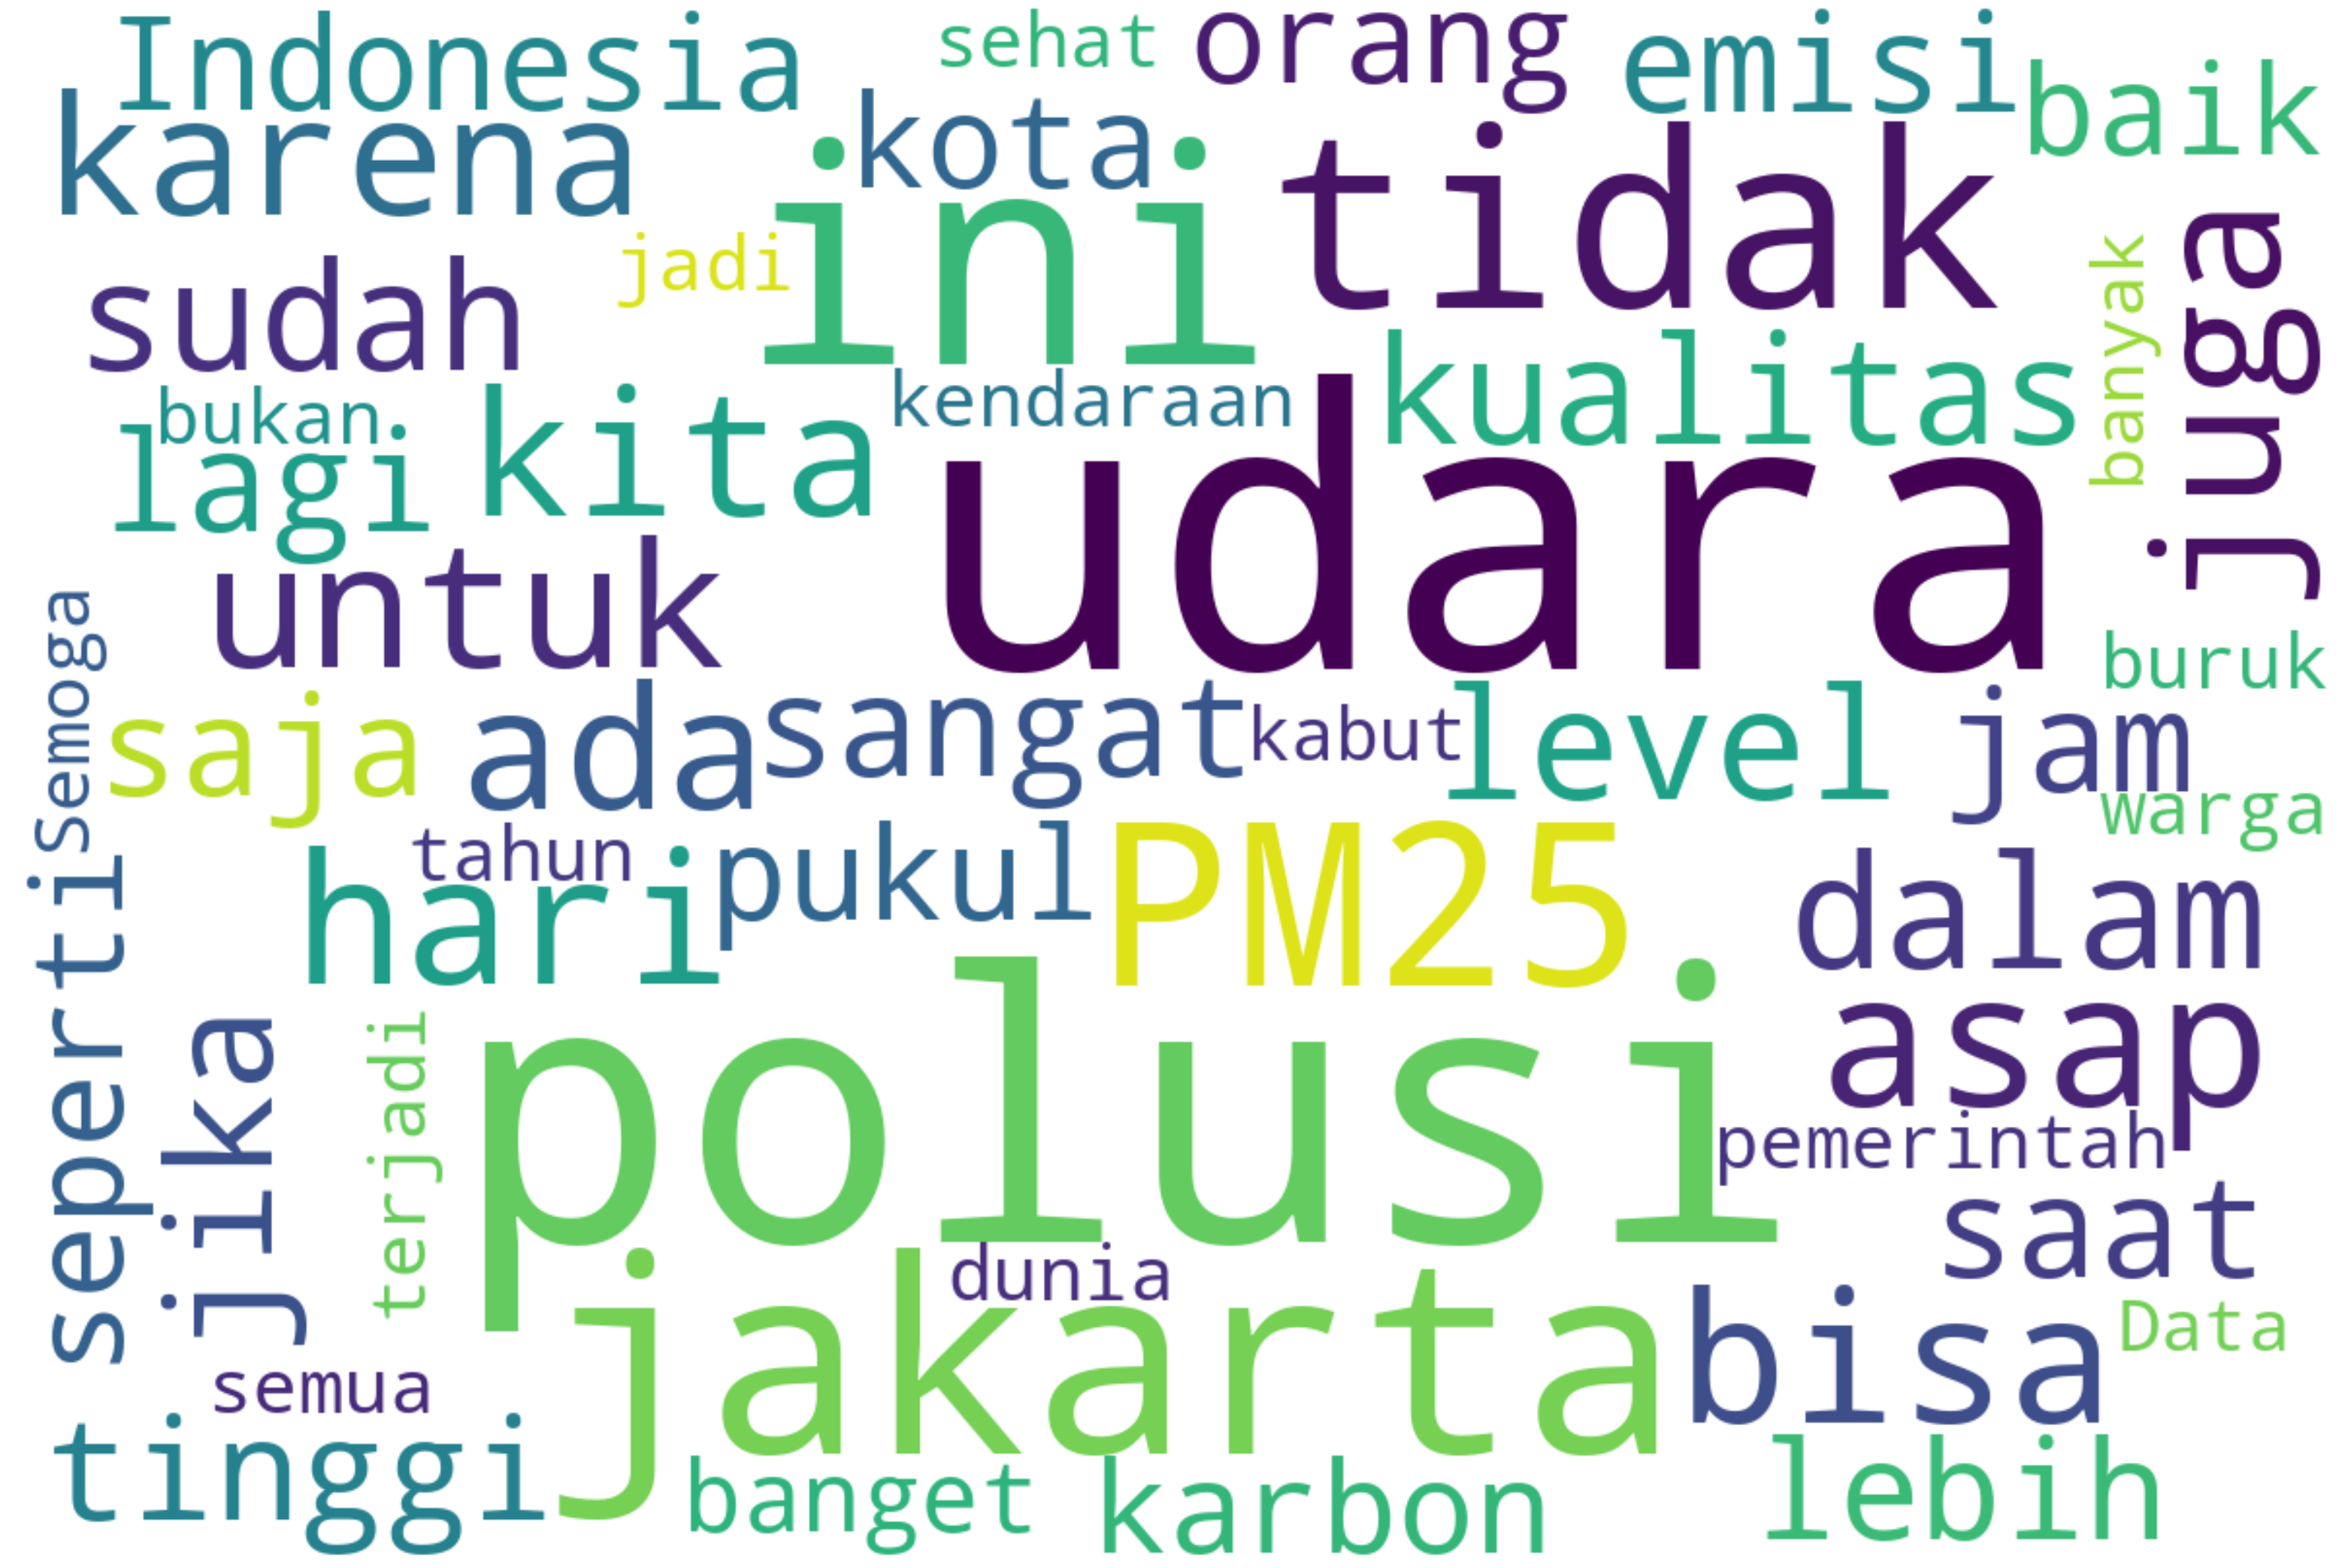

In [ ]:
# @title
#WordCloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Menggabungkan seluruh tweet ke dalam satu string
text = ' '.join(df['Tweet'])

# WordCloud
wordcloud = WordCloud(width=1200, stopwords=stopwords, height=800, max_font_size=200,
                      max_words=50, collocations=False, background_color='white').generate(text)

plt.figure(figsize=(40, 30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Sentiment Modeling using BERT

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 101.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 38.8 MB/s eta 0:00:00


In [ ]:
df['sentimen'] = df['sentimen'].replace(-1, 2)
df['sentimen'].head(5)

0    2
1    0
2    2
3    0
4    2
Name: sentimen, dtype: int64

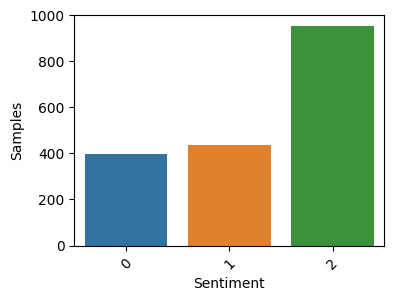

In [ ]:
# Deskriptif
import seaborn as sns
import matplotlib.pyplot as plt

# Menghitung jumlah sampel untuk setiap sentimen
sentimen_counts = df['sentimen'].value_counts()

# Membuat plot bar
plt.figure(figsize=(4, 3))
sns.barplot(x=sentimen_counts.index, y=sentimen_counts)
plt.ylabel('Samples')
plt.xlabel('Sentiment')
plt.xticks(rotation=45)  # Untuk memutar label pada sumbu x jika diperlukan

# Menampilkan plot
plt.show()

In [ ]:
sentences = df.Tweet.values
labels = df.sentimen.values

In [ ]:
from transformers import BertTokenizer
# Tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)

In [ ]:
# Konversi token ke ID
token_ids = tokens.apply(lambda tweet_tokens: tokenizer.convert_tokens_to_ids(tweet_tokens))
print("Tokenized: ")
print(tokens)
print("Token IDs: ")
print(token_ids)


In [ ]:
input_ids = []

for sent in sentences:
  encoded_sent = tokenizer.encode(
      sent,
      add_special_tokens = True
  )
  input_ids.append(encoded_sent)

print("Original: ", sentences[0])
print("Token IDs: ", input_ids[0])

input_ids[0]

In [ ]:
print("Max sentence length: ", max([len(sen) for sen in input_ids]))

Max sentence length:  222


In [ ]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 240

print("Padding/truncating all sentences to %d values" % MAX_LEN)
print('Padding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')

print("Done")

Padding/truncating all sentences to 240 values
Padding token: "[PAD]", ID: 0
Done


In [ ]:
attention_mask = []

for sent in input_ids:
  att_mask = [int(token_id > 0) for token_id in sent]

  attention_mask.append(att_mask)

## Pre-Trained


In [ ]:
pip install torch

In [ ]:
import torch

In [ ]:
from transformers import AutoModel

#Checkpoints
model_ckpt = "bert-base-multilingual-uncased"

#Device selected
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Initiate the model
model = AutoModel.from_pretrained(model_ckpt).to(device)

##Data Splitting

In [ ]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_labels, test_labels = train_test_split(input_ids,
                                                                      labels,
                                                                      random_state=2017,
                                                                      test_size=0.1)
train_mask, test_mask, _, _ = train_test_split(attention_mask,
                                               labels,
                                               random_state=2017,
                                               test_size=0.1)

train_input, validation_input, train_labels, validation_labels = train_test_split(train_input,
                                                                                  train_labels,
                                                                                  random_state=2018,
                                                                                  test_size=0.15)
train_mask, validation_mask, _, _ = train_test_split(train_mask,
                                                     train_mask,
                                                     random_state=2018,
                                                     test_size=0.15)

In [ ]:
import numpy as np
print("== Train ==")
print("Input: ", train_input.shape)
print("Label: ", train_labels.shape)
print("Mask: ", np.array(train_mask).shape)

print("\n== Validation ==")
print("Input: ", validation_input.shape)
print("Label: ", validation_labels.shape)
print("Mask: ", np.array(validation_mask).shape)

print("\n== Test ==")
print("Input: ", test_input.shape)
print("Label: ", test_labels.shape)
print("Mask: ", np.array(test_mask).shape)

== Train ==
Input:  (1365, 240)
Label:  (1365,)
Mask:  (1365, 240)

== Validation ==
Input:  (242, 240)
Label:  (242,)
Mask:  (242, 240)

== Test ==
Input:  (179, 240)
Label:  (179,)
Mask:  (179, 240)


In [ ]:
train_input = torch.tensor(train_input)
train_labels = torch.tensor(train_labels)
train_mask = torch.tensor(train_mask)

validation_input = torch.tensor(validation_input)
validation_labels = torch.tensor(validation_labels)
validation_mask = torch.tensor(validation_mask)

test_input = torch.tensor(test_input)
test_labels = torch.tensor(test_labels)
test_mask = torch.tensor(test_mask)



In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_input, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_input, validation_mask, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_input, test_mask, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

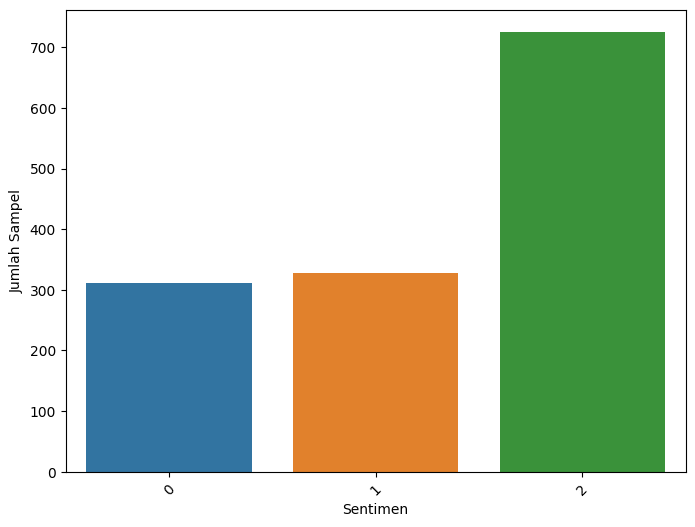

In [ ]:
# Initialize a dictionary to store sentiment counts
sentimen_counts = {0: 0, 1: 0, 2: 0}  # Assuming there are three sentiment classes (0, 1, 2)

# Iterate through the batches in the DataLoader
for batch_input, batch_mask, batch_labels in train_dataloader:
    # batch_labels contains the labels for this batch

    # Iterate through the labels in the batch and update counts
    for label in batch_labels:
        sentimen_counts[label.item()] += 1

# Now you can create the bar plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(x=list(sentimen_counts.keys()), y=list(sentimen_counts.values()))
plt.ylabel('Jumlah Sampel')
plt.xlabel('Sentimen')
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [ ]:
sentimen_counts.values()

dict_values([311, 328, 726])

In [ ]:
import numpy as np
print("== Train ==")
print("Input: ", train_input.shape)
print("Label: ", train_labels.shape)
print("Mask: ", np.array(train_mask).shape)

print("\n== Validation ==")
print("Input: ", validation_input.shape)
print("Label: ", validation_labels.shape)
print("Mask: ", np.array(validation_mask).shape)

print("\n== Test ==")
print("Input: ", test_input.shape)
print("Label: ", test_labels.shape)
print("Mask: ", np.array(test_mask).shape)

== Train ==
Input:  torch.Size([1365, 240])
Label:  torch.Size([1365])
Mask:  (1365, 240)

== Validation ==
Input:  torch.Size([242, 240])
Label:  torch.Size([242])
Mask:  (242, 240)

== Test ==
Input:  torch.Size([179, 240])
Label:  torch.Size([179])
Mask:  (179, 240)


In [ ]:
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [ ]:
# @title
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-uncased",
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False
)

#model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
params = list(model.named_parameters())

print("The BERT model has {:} different named parameters.".format(len(params)))

print("==== Embedding Layer ====")
for p in params[0:5]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== First Transformers ====")
for p in params[5:21]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== Output Layer ====")
for p in params[-4:]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

In [ ]:
from transformers import AdamW

In [ ]:
optimizer = AdamW(
    model.parameters(),
    lr = 2e-5,
    eps = 1e-8
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 8

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                             num_warmup_steps = 0,
                                             num_training_steps = total_steps)

In [ ]:
import numpy as np

def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

## Training BERT

In [ ]:
import torch
import torch.nn as nn
# specify GPU
#device = torch.device('cuda')

In [ ]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs):

  # ===================================
  #              Training
  # ===================================

  print("======= Epoch {:} / {:} =======".format(epoch_i+1, epochs))
  print("Training...")

  t0 = time.time()

  total_loss = 0

  model.train()

  # For each batch of training data
  for step, batch in enumerate(train_dataloader):

    # Progress update every 40 batches
    if step % 40 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)

      print("Batch {:>5,} of {:>5,}.     Elapsed: {:}".format(step, len(train_dataloader), elapsed))

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad()

    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

    loss = outputs[0]

    total_loss += loss.item()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    scheduler.step()

  avg_train_loss = total_loss / len(train_dataloader)

  loss_values.append(avg_train_loss)

  print("   Average training loss: {0:.2f}".format(avg_train_loss))
  print("   Training epoch took: {:}".format(format_time(time.time() - t0)))

  # ===================================
  #             Validation
  # ===================================

  print("Running Validation...")

  t0 = time.time()

  model.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader:

    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy

    nb_eval_steps += 1

  print("   Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
  print("   Validation took: {:}".format(format_time(time.time() - t0)))

print("Training complete!")

======= Epoch 1 / 8 =======
Training...


RuntimeError: ignored

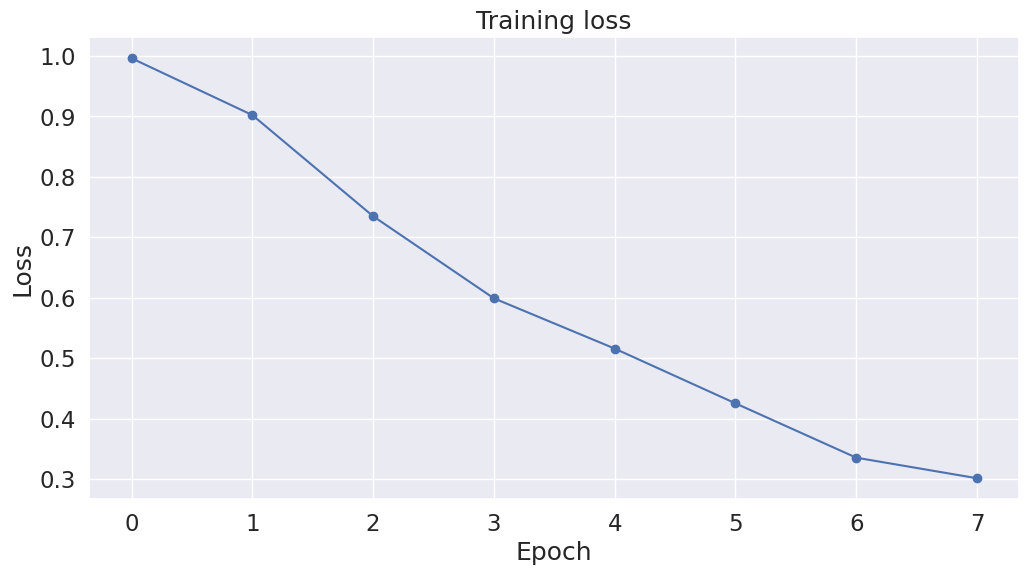

In [ ]:
import matplotlib.pyplot as plt

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
print("Predicting labels for {:,} test sentences".format(len(test_input)))

model.eval()

prediction, true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  prediction.append(logits)
  true_labels.append(label_ids)

print(" DONE.")

Predicting labels for 179 test sentences
 DONE.


In [ ]:
from sklearn.metrics import matthews_corrcoef

flat_prediction = [item for sublist in prediction for item in sublist]
flat_prediction = np.argmax(flat_prediction, axis=1).flatten()

flat_true_labels = [item for sublist in true_labels for item in sublist]

mcc = matthews_corrcoef(flat_true_labels, flat_prediction)

print("MCC: %.3f" %mcc)

MCC: 0.400


In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(flat_true_labels, flat_prediction)

print("ACC: %.3f" %acc)

ACC: 0.654


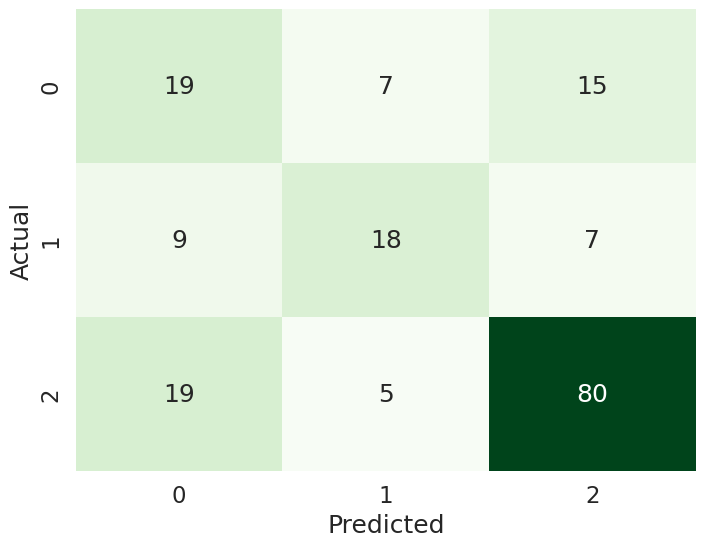

In [ ]:
# Mengubah ke bentuk kolom
true_labels_col = np.array(flat_true_labels)
prediction_col = np.array(flat_prediction)
from sklearn.metrics import confusion_matrix
# Membuat confusion matrix
confusion = confusion_matrix(flat_true_labels, flat_prediction)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# Membuat laporan klasifikasi
target_names = ['Netral', 'Positif', 'Negatif']
report = classification_report(flat_true_labels, flat_prediction, target_names=target_names)

# Menampilkan laporan klasifikasi
print(report)

              precision    recall  f1-score   support

      Netral       0.40      0.46      0.43        41
     Positif       0.60      0.53      0.56        34
     Negatif       0.78      0.77      0.78       104

    accuracy                           0.65       179
   macro avg       0.60      0.59      0.59       179
weighted avg       0.66      0.65      0.66       179



# Modeling with Balanced Data

In [ ]:
import pandas as pd
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [ ]:
df = pd.read_csv("/content/sentimen polusi indonesia - labeled.csv", delimiter=',')
print(df.shape)
df['Tweet'].head(5)

In [ ]:
df['sentimen'] = df['sentimen'].replace(-1, 2)
df['sentimen'].value_counts()

2    955
1    435
0    396
Name: sentimen, dtype: int64

In [ ]:
from sklearn.utils import resample

## Balancing - Mengurangi kelas Mayor

In [ ]:
df_neutral = df[(df['sentimen']==0)]
df_negative = df[(df['sentimen']==2)]
df_positive = df[(df['sentimen']==1)]

# upsample minority classes
df_negative_upsampled = resample(df_negative,
                                 replace=True,
                                 n_samples= 396,
                                 random_state=42)

df_positive_upsampled = resample(df_positive,
                                 replace=True,
                                 n_samples= 396,
                                 random_state=42)


# Concatenate the upsampled dataframes with the neutral dataframe
df = pd.concat([df_negative_upsampled,df_neutral,df_positive_upsampled])

In [ ]:
df['sentimen'].value_counts()

2    396
0    396
1    396
Name: sentimen, dtype: int64

In [ ]:
# Menghitung jumlah sampel dalam kelas mayoritas (kelas 'neutral')
count_neutral = len(df_neutral)

# Menghitung jumlah sampel yang diambil dari kelas minoritas (kelas 'negative' dan 'positive')
n_samples_upsampled = 396  # Jumlah sampel yang diambil selama proses upsampling

# Menghitung jumlah sisa sampel dalam kelas minoritas
n_samples_remaining = count_neutral - n_samples_upsampled

# Mengambil sisa sampel dari kelas minoritas (kelas 'negative' dan 'positive')
df_negative_remaining = df_negative.iloc[n_samples_upsampled:]
df_positive_remaining = df_positive.iloc[n_samples_upsampled:]

# Menggabungkan data yang tersisa dengan data 'neutral' dan data yang telah diupsample
df_remaining = pd.concat([df_negative_remaining, df_positive_remaining, df_neutral])

# Sekarang df_remaining berisi sisa data yang tidak diambil selama upsampling

In [ ]:
df = pd.DataFrame(df)
df_remaining = pd.DataFrame(df_remaining)

In [ ]:
import pandas as pd
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# Preprocessing

xs = df['Tweet'].str.lower()  # Mengubah teks menjadi lowercase
xs = xs.apply(lambda x: re.sub(r'\d+', '', x))  # Menghapus angka
xs = xs.apply(lambda x: x.translate(str.maketrans('', '',string.punctuation))) #Menghapus tanda baca
xs = xs.apply(lambda x: word_tokenize(x))  # Tokenisasi kata-kata
ys = df_remaining['Tweet'].str.lower()  # Mengubah teks menjadi lowercase
ys = ys.apply(lambda y: re.sub(r'\d+', '', y))  # Menghapus angka
ys = ys.apply(lambda y: y.translate(str.maketrans('', '',string.punctuation))) #Menghapus tanda baca
ys = ys.apply(lambda y: word_tokenize(y))  # Tokenisasi kata-kata


# Menghapus stopwords
stop_words = set(stopwords.words('indonesian'))
xs = xs.apply(lambda tokens: [word for word in tokens if word not in stop_words])
ys = ys.apply(lambda tokens: [word for word in tokens if word not in stop_words])

In [ ]:
# Stemming (Memecah kata dasar) menggunakan PySastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

tokens = xs.apply(lambda tokens: [stemmer.stem(word) for word in tokens])
tokensy = ys.apply(lambda tokensy: [stemmer.stem(word) for word in tokensy])

In [ ]:
sentences = df.Tweet.values
labels = df.sentimen.values
sentencesy = df_remaining.Tweet.values
labelsy = df_remaining.sentimen.values

In [ ]:
from transformers import BertTokenizer
# Tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)

In [ ]:
# Konversi token ke ID
token_ids = tokens.apply(lambda tweet_tokens: tokenizer.convert_tokens_to_ids(tweet_tokens))
token_idsy = tokensy.apply(lambda tweet_tokensy: tokenizer.convert_tokens_to_ids(tweet_tokensy))
print("Tokenized: ")
print(tokens)
print("Token IDs: ")
print(token_ids)

In [ ]:
input_ids = []
input_idsy = []


for sent in sentences:
  encoded_sent = tokenizer.encode(
      sent,
      add_special_tokens = True
  )
  input_ids.append(encoded_sent)

print("Original: ", sentences[0])
print("Token IDs: ", input_ids[0])

input_ids[0]

for sent in sentencesy:
  encoded_sent = tokenizer.encode(
      sent,
      add_special_tokens = True
  )
  input_idsy.append(encoded_sent)

print("Original: ", sentencesy[0])
print("Token IDs: ", input_idsy[0])

Original:  evakuasi kemana bang semua tempat berasap
Token IDs:  [101, 16927, 74133, 10459, 47304, 11801, 12221, 21417, 16728, 60571, 10462, 10373, 102]
Original:  Warga Depok Bogor dan Bandung usia harapan hidupnya berkurang 6 tahun lebih akibat polusi udara. Warga kota mana saja di Indonesia yang usianya diperpendek karena polusi udara? Silakan baca selengkapnya liputan jurnalisme data @hariankompas ini gaes
kompas.id/baca/investigasi/2…
Token IDs:  [101, 43546, 10102, 41938, 63390, 10214, 33302, 50688, 93244, 19242, 10753, 64560, 59822, 10422, 127, 11063, 13619, 43451, 48596, 10459, 23787, 119, 43546, 13874, 17468, 29631, 10120, 11393, 10290, 50688, 10753, 80044, 10177, 95111, 10167, 15368, 48596, 10459, 23787, 136, 33758, 10809, 13775, 10112, 75546, 93394, 10753, 87823, 28153, 80733, 50377, 17678, 10248, 137, 88661, 13228, 19933, 10643, 11747, 10165, 12250, 19933, 119, 12249, 120, 13775, 10112, 120, 10104, 54093, 70676, 120, 123, 100, 102]


In [ ]:
print("Max sentence length: ", max([len(sen) for sen in input_ids]))

Max sentence length:  222


In [ ]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 240

print("Padding/truncating all sentences to %d values" % MAX_LEN)
print('Padding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')
input_idsy = pad_sequences(input_idsy, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')

print("Done")

Padding/truncating all sentences to 240 values
Padding token: "[PAD]", ID: 0
Done


In [ ]:
attention_mask = []

for sent in input_ids:
  att_mask = [int(token_id > 0) for token_id in sent]

  attention_mask.append(att_mask)

attention_masky = []

for sent in input_idsy:
  att_mask = [int(token_id > 0) for token_id in sent]

  attention_masky.append(att_mask)

In [ ]:
from transformers import AutoModel

#Checkpoints
model_ckpt = "bert-base-multilingual-uncased"

#Device selected
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Initiate the model
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [ ]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_labels, test_labels = train_test_split(input_ids,
                                                                      labels,
                                                                      random_state=2017,
                                                                      test_size=0.1)
train_mask, test_mask, _, _ = train_test_split(attention_mask,
                                               labels,
                                               random_state=2017,
                                               test_size=0.1)

train_input, validation_input, train_labels, validation_labels = train_test_split(train_input,
                                                                                  train_labels,
                                                                                  random_state=2018,
                                                                                  test_size=0.15)
train_mask, validation_mask, _, _ = train_test_split(train_mask,
                                                     train_mask,
                                                     random_state=2018,
                                                     test_size=0.15)

In [ ]:
test_input = np.concatenate((test_input,input_idsy),axis=0)
test_labels = np.concatenate((test_labels,df_remaining['sentimen']),axis=0)
test_mask = np.concatenate((test_mask,attention_masky),axis=0)

In [ ]:
import numpy as np
print("== Train ==")
print("Input: ", train_input.shape)
print("Label: ", train_labels.shape)
print("Mask: ", np.array(train_mask).shape)

print("\n== Validation ==")
print("Input: ", validation_input.shape)
print("Label: ", validation_labels.shape)
print("Mask: ", np.array(validation_mask).shape)

print("\n== Test ==")
print("Input: ", test_input.shape)
print("Label: ", test_labels.shape)
print("Mask: ", np.array(test_mask).shape)

== Train ==
Input:  (908, 240)
Label:  (908,)
Mask:  (908, 240)

== Validation ==
Input:  (161, 240)
Label:  (161,)
Mask:  (161, 240)

== Test ==
Input:  (1113, 240)
Label:  (1113,)
Mask:  (1113, 240)


In [ ]:
train_input = torch.tensor(train_input)
train_labels = torch.tensor(train_labels)
train_mask = torch.tensor(train_mask)

validation_input = torch.tensor(validation_input)
validation_labels = torch.tensor(validation_labels)
validation_mask = torch.tensor(validation_mask)

test_input = torch.tensor(test_input)
test_labels = torch.tensor(test_labels)
test_mask = torch.tensor(test_mask)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_input, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_input, validation_mask, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_input, test_mask, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
import numpy as np
print("== Train ==")
print("Input: ", train_input.shape)
print("Label: ", train_labels.shape)
print("Mask: ", np.array(train_mask).shape)

print("\n== Validation ==")
print("Input: ", validation_input.shape)
print("Label: ", validation_labels.shape)
print("Mask: ", np.array(validation_mask).shape)

print("\n== Test ==")
print("Input: ", test_input.shape)
print("Label: ", test_labels.shape)
print("Mask: ", np.array(test_mask).shape)

In [ ]:
# @title
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-uncased",
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False
)

model.cuda()

In [ ]:
params = list(model.named_parameters())

print("The BERT model has {:} different named parameters.".format(len(params)))

print("==== Embedding Layer ====")
for p in params[0:5]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== First Transformers ====")
for p in params[5:21]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== Output Layer ====")
for p in params[-4:]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

In [ ]:
optimizer = AdamW(
    model.parameters(),
    lr = 2e-5,
    eps = 1e-8
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 5

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                             num_warmup_steps = 0,
                                             num_training_steps = total_steps)

In [ ]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs):

  # ===================================
  #              Training
  # ===================================

  print("======= Epoch {:} / {:} =======".format(epoch_i+1, epochs))
  print("Training...")

  t0 = time.time()

  total_loss = 0

  model.train()

  # For each batch of training data
  for step, batch in enumerate(train_dataloader):

    # Progress update every 40 batches
    if step % 40 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)

      print("Batch {:>5,} of {:>5,}.     Elapsed: {:}".format(step, len(train_dataloader), elapsed))

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad()

    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

    loss = outputs[0]

    total_loss += loss.item()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    scheduler.step()

  avg_train_loss = total_loss / len(train_dataloader)

  loss_values.append(avg_train_loss)

  print("   Average training loss: {0:.2f}".format(avg_train_loss))
  print("   Training epoch took: {:}".format(format_time(time.time() - t0)))

  # ===================================
  #             Validation
  # ===================================

  print("Running Validation...")

  t0 = time.time()

  model.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader:

    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy

    nb_eval_steps += 1

  print("   Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
  print("   Validation took: {:}".format(format_time(time.time() - t0)))

print("Training complete!")

======= Epoch 1 / 5 =======
Training...
   Average training loss: 1.08
   Training epoch took: 0:00:39
Running Validation...
   Accuracy: 0.39
   Validation took: 0:00:02
======= Epoch 2 / 5 =======
Training...
   Average training loss: 0.96
   Training epoch took: 0:00:34
Running Validation...
   Accuracy: 0.46
   Validation took: 0:00:02
======= Epoch 3 / 5 =======
Training...
   Average training loss: 0.81
   Training epoch took: 0:00:35
Running Validation...
   Accuracy: 0.48
   Validation took: 0:00:02
======= Epoch 4 / 5 =======
Training...
   Average training loss: 0.71
   Training epoch took: 0:00:35
Running Validation...
   Accuracy: 0.50
   Validation took: 0:00:02
======= Epoch 5 / 5 =======
Training...
   Average training loss: 0.65
   Training epoch took: 0:00:35
Running Validation...
   Accuracy: 0.52
   Validation took: 0:00:02
Training complete!


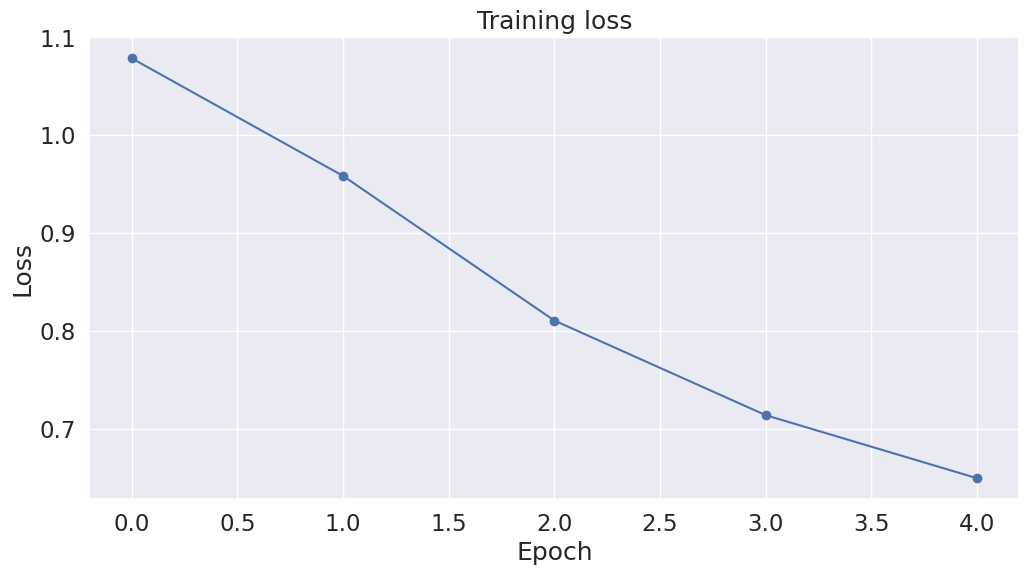

In [ ]:
import matplotlib.pyplot as plt

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
print("Predicting labels for {:,} test sentences".format(len(test_input)))

model.eval()

prediction, true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  prediction.append(logits)
  true_labels.append(label_ids)

print(" DONE.")

Predicting labels for 1,113 test sentences
 DONE.


In [ ]:
from sklearn.metrics import matthews_corrcoef

flat_prediction = [item for sublist in prediction for item in sublist]
flat_prediction = np.argmax(flat_prediction, axis=1).flatten()

flat_true_labels = [item for sublist in true_labels for item in sublist]

mcc = matthews_corrcoef(flat_true_labels, flat_prediction)

print("MCC: %.3f" %mcc)

MCC: 0.357


In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(flat_true_labels, flat_prediction)

print("ACC: %.3f" %acc)

ACC: 0.567


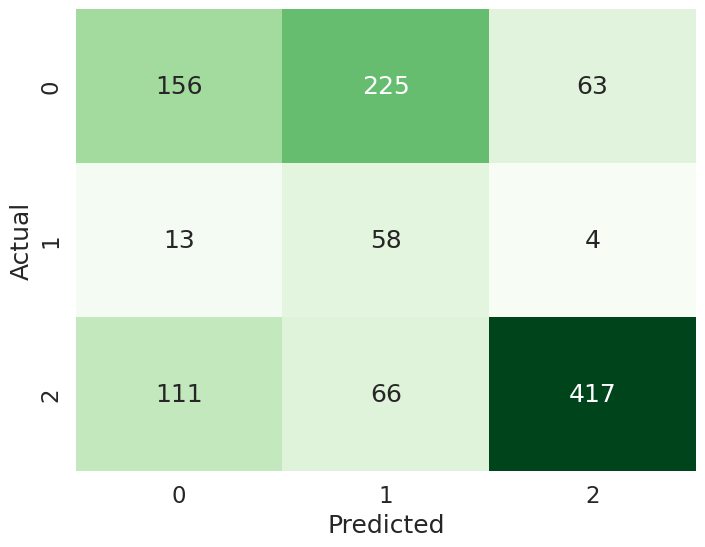

In [ ]:
# Mengubah ke bentuk kolom
true_labels_col = np.array(flat_true_labels)
prediction_col = np.array(flat_prediction)
from sklearn.metrics import confusion_matrix
# Membuat confusion matrix
confusion = confusion_matrix(flat_true_labels, flat_prediction)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# Membuat laporan klasifikasi
target_names = ['Netral', 'Positif', 'Negatif']
report = classification_report(flat_true_labels, flat_prediction, target_names=target_names)

# Menampilkan laporan klasifikasi
print(report)

              precision    recall  f1-score   support

      Netral       0.69      0.65      0.67        48
     Positif       0.77      0.83      0.80        36
     Negatif       0.71      0.71      0.71        35

    accuracy                           0.72       119
   macro avg       0.72      0.73      0.73       119
weighted avg       0.72      0.72      0.72       119

